Construct a model for scoring
-----------------

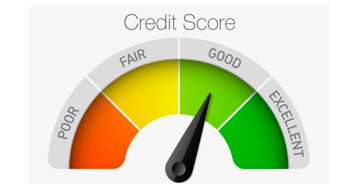

**The main objective of the project is to create a credit scoring algorithm that predicts the chance of a given loan applicant defaulting on loan repayment.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
import shap
from shap import TreeExplainer, summary_plot
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.metrics import roc_auc_score
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import fbeta_score, make_scorer

### I import the csv file

In [2]:
df=pd.read_csv('application_train.csv', sep =',')

In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [5]:
df.shape

(307511, 122)

In [6]:
list(df.select_dtypes(['number']).columns)

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAR

In [7]:
list(df.select_dtypes(['object']).columns)

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [8]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


### We perform some EDA 

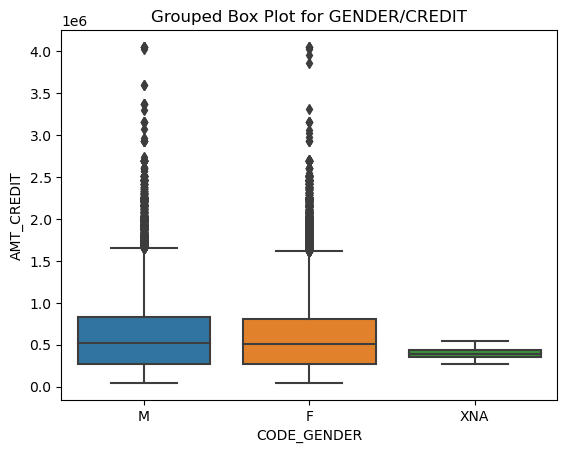

In [9]:
sns.boxplot(x='CODE_GENDER', y='AMT_CREDIT', data=df).set_title('Grouped Box Plot for GENDER/CREDIT');

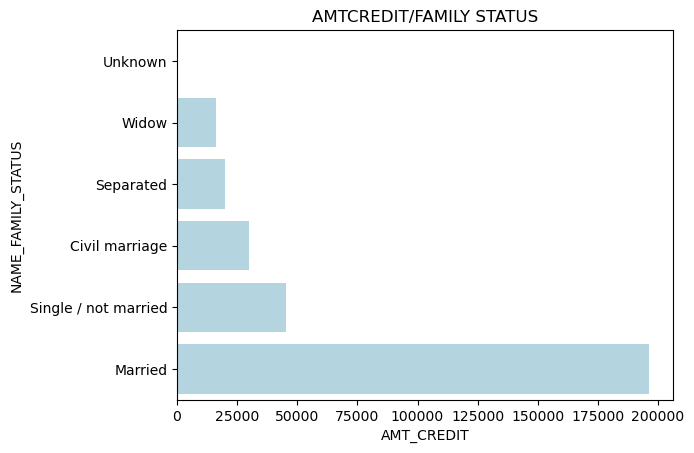

In [10]:
res = df.groupby(['NAME_FAMILY_STATUS'])['AMT_CREDIT'].count().reset_index().sort_values('AMT_CREDIT')
ax=sns.barplot(x='AMT_CREDIT', y='NAME_FAMILY_STATUS', color='lightblue', data=res).set_title('AMTCREDIT/FAMILY STATUS');

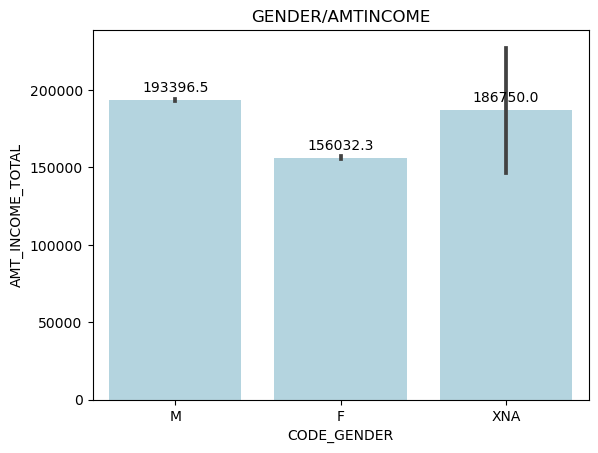

In [11]:
g= sns.barplot(x='CODE_GENDER', y='AMT_INCOME_TOTAL', color='lightblue', data=df)
for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    g.set_title('GENDER/AMTINCOME')

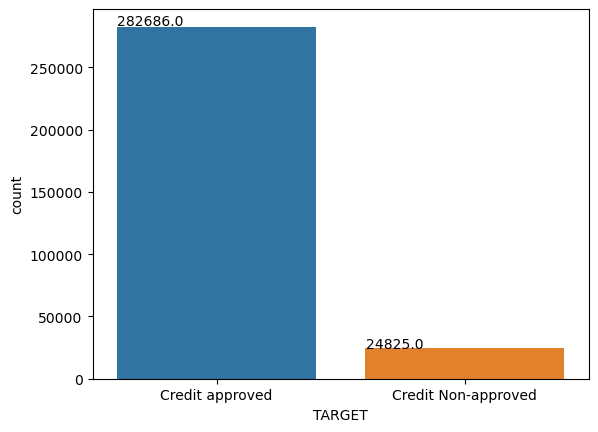

In [12]:
s = sns.countplot(x = 'TARGET',data = df)
for p in s.patches:
    s.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    s.set_xticklabels(['Credit approved','Credit Non-approved']);

0 means actually the credit is given and 1 means the credit is rejected.

In [13]:
r1 = df.groupby(['CNT_CHILDREN'])['AMT_CREDIT'].count().reset_index().sort_values('AMT_CREDIT')

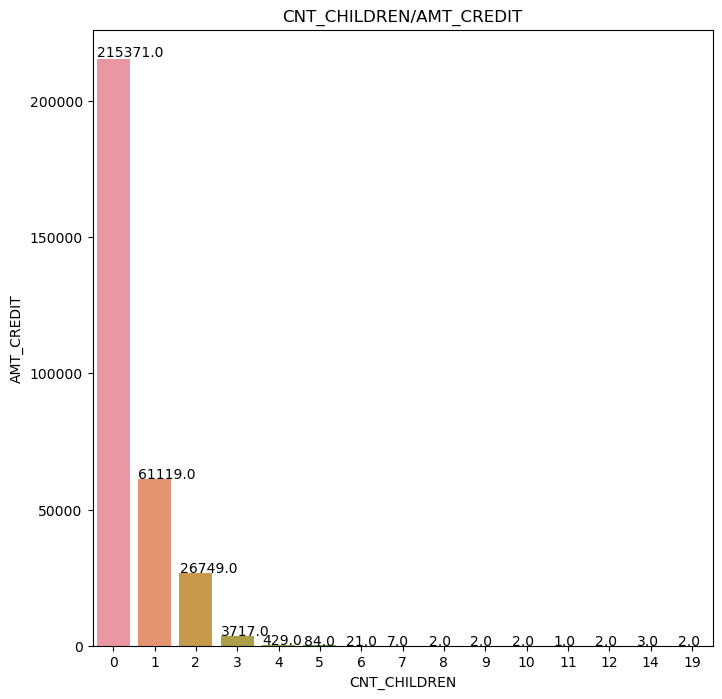

In [14]:
plt.figure(figsize=(8, 8))
s = sns.barplot(x='CNT_CHILDREN', y='AMT_CREDIT', data=r1)
for p in s.patches:
    s.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.title("CNT_CHILDREN/AMT_CREDIT")

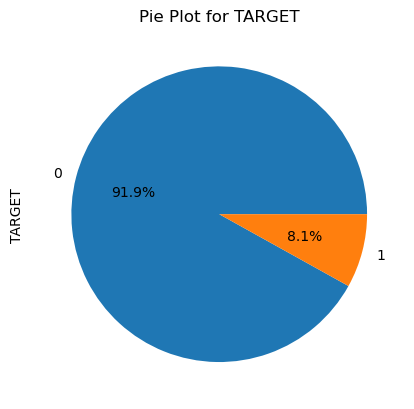

In [15]:
df['TARGET'].value_counts().plot.pie(center=(0, 0), radius=1.0, autopct='%1.1f%%').set_title('Pie Plot for TARGET');

### The data is imbalanced

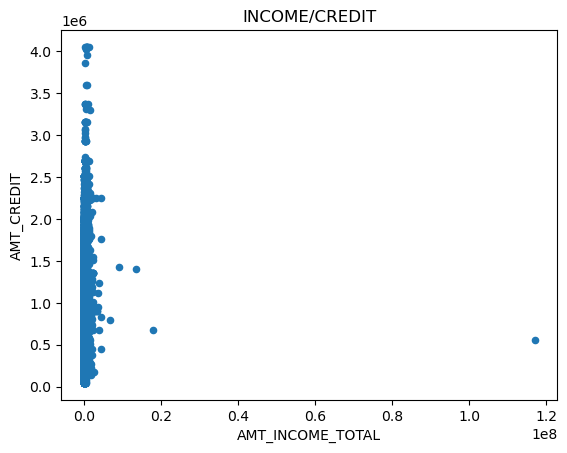

In [16]:
df.plot(kind = 'scatter', x="AMT_INCOME_TOTAL", y="AMT_CREDIT", title="INCOME/CREDIT");

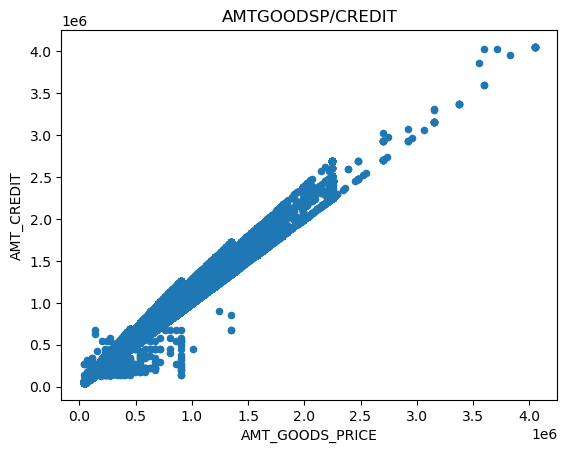

In [17]:
df.plot(kind = 'scatter', x="AMT_GOODS_PRICE", y="AMT_CREDIT", title="AMTGOODSP/CREDIT");

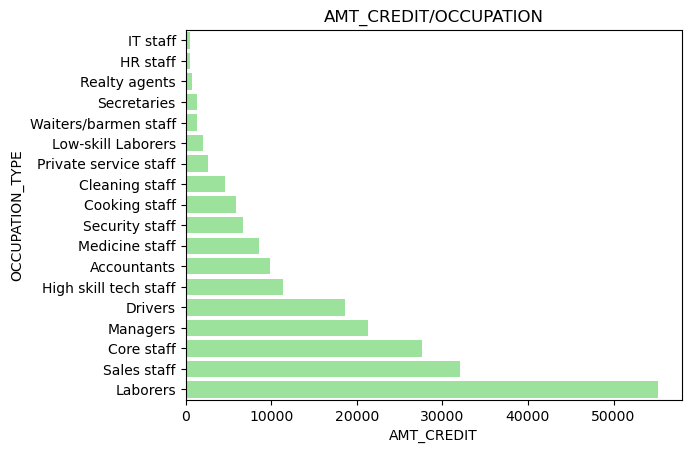

In [18]:
result = df.groupby(["OCCUPATION_TYPE"])['AMT_CREDIT'].count().reset_index().sort_values('AMT_CREDIT')
sns.barplot(x='AMT_CREDIT', y='OCCUPATION_TYPE', color='lightgreen', data=result)
plt.title("AMT_CREDIT/OCCUPATION");

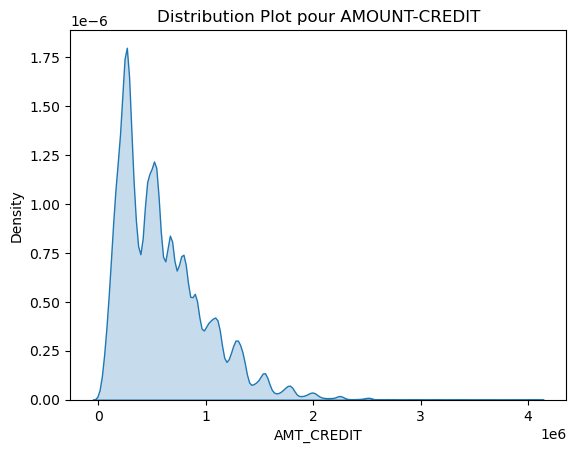

In [19]:
sns.kdeplot(df['AMT_CREDIT'], fill=True).set_title('Distribution Plot pour AMOUNT-CREDIT');

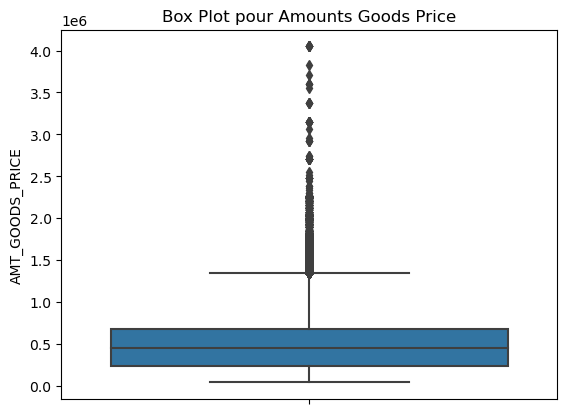

In [20]:
sns.boxplot(y='AMT_GOODS_PRICE', data=df).set_title('Box Plot pour Amounts Goods Price');

**Get rid of the outliers**

In [21]:
# In order to remove the data we use capping;
def cap_data(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

df=cap_data(df)

In [22]:
df.shape

(307511, 122)

In [23]:
#Get rid of the outliers for AMT_GOODS_PRICE
#percentile25 = df['AMT_GOODS_PRICE'].quantile(0.25)
#percentile75 = df['AMT_GOODS_PRICE'].quantile(0.75)
#iqr=percentile75-percentile25

In [24]:
#upper_limit = percentile75 + 1.5 * iqr
#lower_limit = percentile25 - 1.5 * iqr

In [25]:
#df=df[df['AMT_GOODS_PRICE'] < upper_limit] 

In [26]:
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [27]:
X1=df.select_dtypes('object')

In [28]:
X1.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [29]:
X1['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [30]:
X1['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

In [31]:
X1['EMERGENCYSTATE_MODE'].value_counts()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [32]:
X1.isnull().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [33]:
X1= X1.drop(columns=['FONDKAPREMONT_MODE','HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'])

In [34]:
X1.isnull().sum()

NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
NAME_TYPE_SUITE                1292
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
OCCUPATION_TYPE               96391
WEEKDAY_APPR_PROCESS_START        0
ORGANIZATION_TYPE                 0
dtype: int64

In [35]:
df['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [36]:
col=['OCCUPATION_TYPE', 'NAME_TYPE_SUITE']
for x in col:
    X1[x]=X1[x].fillna(X1[x].mode()[0])

In [37]:
X1.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion


In [38]:
X1.shape

(307511, 12)

In [39]:
X2 = df._get_numeric_data()

In [40]:
X2.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [41]:
X2.shape

(307511, 106)

In [42]:
#X2[X2['AMT_REQ_CREDIT_BUREAU_QRT'].isnull() == True]

In [43]:
X2 = X2.drop(columns=['REG_REGION_NOT_LIVE_REGION', 
                      'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
                      'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                      'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 
                      'EXT_SOURCE_2','EXT_SOURCE_3', 'APARTMENTS_AVG', 
                      'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 
                      'YEARS_BUILD_AVG', 'COMMONAREA_AVG','ELEVATORS_AVG', 
                      'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 
                      'LIVINGAPARTMENTS_AVG'])

In [44]:
X2.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       

In [45]:
col=['DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'AMT_GOODS_PRICE', 'OBS_60_CNT_SOCIAL_CIRCLE', 
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'BASEMENTAREA_MODE', 'LANDAREA_MODE', 'LANDAREA_MEDI',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'OWN_CAR_AGE', 'NONLIVINGAPARTMENTS_AVG',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'ELEVATORS_MEDI', 'NONLIVINGAREA_MEDI',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'BASEMENTAREA_MEDI',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'APARTMENTS_MODE', 
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'APARTMENTS_MEDI', 'ELEVATORS_MODE', 'TOTALAREA_MODE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_60_CNT_SOCIAL_CIRCLE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'LIVINGAREA_AVG',
     'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'AMT_ANNUITY',
     'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'COMMONAREA_MODE', 'COMMONAREA_MEDI',
    'DEF_30_CNT_SOCIAL_CIRCLE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'CNT_FAM_MEMBERS']
for x in col:
    X2[x]=X2[x].fillna(X2[x].mean())

In [46]:
X2.isnull().mean().sort_values()

SK_ID_CURR                    0.0
FLAG_DOCUMENT_3               0.0
FLAG_DOCUMENT_2               0.0
DAYS_LAST_PHONE_CHANGE        0.0
DEF_60_CNT_SOCIAL_CIRCLE      0.0
                             ... 
NONLIVINGAREA_AVG             0.0
NONLIVINGAPARTMENTS_AVG       0.0
LIVINGAREA_AVG                0.0
ELEVATORS_MODE                0.0
AMT_REQ_CREDIT_BUREAU_YEAR    0.0
Length: 86, dtype: float64

### Now we concate the two dataframes

In [47]:
X = pd.concat([X1, X2], axis=1, join="inner")

In [48]:
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,1.000000
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,0.000000
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,0.000000
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,...,0,0,0,0,0.0,0.0,0.032091,0.236218,0.25297,1.893237
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,0.000000


In [49]:
X.shape

(307511, 98)

In [50]:
X.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

### Use Ordinal encoder to change category into numbers 

In [51]:
le = OrdinalEncoder()
X[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'ORGANIZATION_TYPE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE']] = le.fit_transform(X[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'ORGANIZATION_TYPE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE']])

In [52]:
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.0,M,0.0,1.0,Unaccompanied,Working,4.0,Single / not married,House / apartment,Laborers,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,1.000000
1,0.0,F,0.0,0.0,Family,State servant,1.0,Married,House / apartment,Core staff,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,0.000000
2,1.0,M,1.0,1.0,Unaccompanied,Working,4.0,Single / not married,House / apartment,Laborers,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,0.000000
3,0.0,F,0.0,1.0,Unaccompanied,Working,4.0,Civil marriage,House / apartment,Laborers,...,0,0,0,0,0.0,0.0,0.032091,0.236218,0.25297,1.893237
4,0.0,M,0.0,1.0,Unaccompanied,Working,4.0,Single / not married,House / apartment,Core staff,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,0.000000


### Use One hot encoding on the remaining categorical data

In [53]:
X=pd.get_dummies(X, drop_first=True)

In [54]:
X.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,ORGANIZATION_TYPE,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,0.0,0.0,1.0,4.0,5.0,103590.2,1,0,202500.0,406597.5,...,0,0,0,0,0,0,0,0,0,1
1,0.0,0.0,0.0,1.0,39.0,103590.2,0,0,270000.0,1293502.5,...,0,0,0,0,1,0,0,0,0,0
2,1.0,1.0,1.0,4.0,11.0,103590.2,0,0,67500.0,135000.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,0.0,1.0,4.0,5.0,103590.2,0,0,135000.0,312682.5,...,0,0,0,0,0,0,0,0,0,1
4,0.0,0.0,1.0,4.0,37.0,103590.2,0,0,121500.0,513000.0,...,0,0,0,0,0,0,0,1,0,0


In [55]:
X.shape

(307511, 139)

Now we create a dataframe which does not have the TARGET variable. We also drop some more column which we think is not required

In [56]:
A = X.drop(columns=['TARGET','FLAG_DOCUMENT_2', 'SK_ID_CURR',
                     'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
                     'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 
                     'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
                     'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
                     'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 
                     'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'])

In [57]:
B = X['TARGET']

### Feature Selection

**In order to find the important features of the data we use XGB classifier**

In [58]:
model = XGBClassifier(eval_metric='logloss')
model.fit(A, B)
# feature importance
print(model.feature_importances_)

[0.02222463 0.02107321 0.00683436 0.05402948 0.0074365  0.00670599
 0.00685178 0.01455762 0.01114371 0.01524778 0.00820372 0.01391635
 0.01235141 0.00722557 0.00931893 0.01209259 0.         0.01806062
 0.01327554 0.         0.00741482 0.00588145 0.00736867 0.01279225
 0.02621233 0.00671085 0.00733368 0.00692126 0.007013   0.00651645
 0.00699013 0.00585439 0.00656777 0.00637763 0.00440215 0.00598074
 0.00625647 0.00607237 0.00705666 0.00684888 0.00602271 0.00592428
 0.00734736 0.00674168 0.00716865 0.00992692 0.00568009 0.00581174
 0.00757825 0.00894747 0.01488934 0.0073427  0.00750949 0.00677895
 0.00633256 0.00682563 0.00715054 0.00708179 0.00588086 0.01509707
 0.00760137 0.00791456 0.01018337 0.         0.         0.00756739
 0.00627505 0.00862545 0.00935924 0.03458716 0.         0.00471448
 0.         0.00335678 0.00945636 0.00589615 0.00789989 0.00572577
 0.         0.         0.00787268 0.         0.01147047 0.05047454
 0.01747533 0.00616892 0.00905273 0.         0.00477927 0.0090

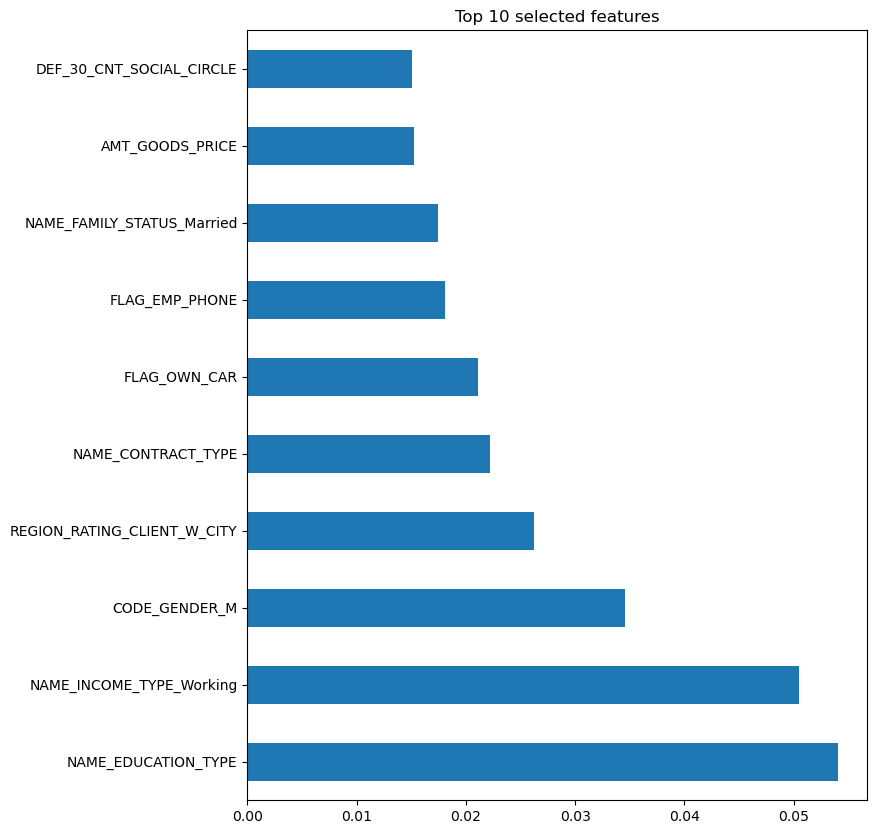

In [59]:
feat_imp = pd.Series(model.feature_importances_, index=A.columns)
feat_imp.nlargest(10).plot(kind='barh', figsize=(8,10))
plt.title("Top 10 selected features")
plt.show()

In [60]:
f=feat_imp.nlargest(10).index.tolist()
f

['NAME_EDUCATION_TYPE',
 'NAME_INCOME_TYPE_Working',
 'CODE_GENDER_M',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_EMP_PHONE',
 'NAME_FAMILY_STATUS_Married',
 'AMT_GOODS_PRICE',
 'DEF_30_CNT_SOCIAL_CIRCLE']

In [61]:
unwanted = []
for col in A.columns:
    if col not in feat_imp.nlargest(85):
        unwanted.append(col)

In [62]:
print(unwanted)

['FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'CODE_GENDER_XNA', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student', 'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Waiters/barmen staff', 'WEEKDAY_APPR_PROCESS_START_THURSDAY']


In [63]:
# We consider only top 85 features
A.drop(columns=unwanted,inplace=True)
A.sample(5)

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,ORGANIZATION_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
64852,0.0,0.0,1.0,4.0,5.0,0,135000.0,526491.0,33777.0,454500.0,...,0,0,0,1,0,0,0,0,1,0
38771,0.0,1.0,0.0,4.0,24.0,1,112500.0,276277.5,12168.0,238500.0,...,0,0,0,0,0,0,0,0,1,0
44254,0.0,1.0,1.0,4.0,1.0,2,202500.0,225000.0,12334.5,225000.0,...,0,0,0,0,0,0,0,0,1,0
109407,0.0,0.0,1.0,1.0,5.0,0,247500.0,344043.0,24597.0,297000.0,...,0,0,0,0,0,0,0,0,1,0
174675,0.0,0.0,1.0,4.0,57.0,0,90000.0,454500.0,20020.5,454500.0,...,0,0,0,0,0,0,0,0,0,1


In [64]:
A.shape

(307511, 85)

**Create three new columns**

In [65]:
A['NEW_DAYS_EMPLOYED'] = A['DAYS_EMPLOYED'] / A['DAYS_BIRTH']
A['NEW_INCOME_CREDIT'] = A['AMT_INCOME_TOTAL'] / A['AMT_CREDIT']
#A['NEW_INCOME_PER_PERSON'] = A['AMT_INCOME_TOTAL'] / A['CNT_FAM_MEMBERS']

In [66]:
A.corr().shape[0]

87

In [67]:
# Create correlation matrix
corr_matrix = A.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
A.drop(columns=to_drop, inplace=True)

In [68]:
A.shape

(307511, 72)

In [69]:
A.columns

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'YEARS_BEGINEXPLUATATION_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'TOTALAREA_MODE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QR

In [70]:
B.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [71]:
#A1=A.drop(columns=['NEW_INCOME_CREDIT'])

In [72]:
#A1 = pd.concat([A, C], axis=1, join="inner")
#A1.shape

### Since the data is  big we use down-sampling to balance the data

In [73]:
from imblearn.under_sampling import RandomUnderSampler 

nm= RandomUnderSampler()
X, y=nm.fit_resample(A, B)

In [74]:
X.shape, y.shape

((49650, 72), (49650,))

In [75]:
y.value_counts()

0    24825
1    24825
Name: TARGET, dtype: int64

### Oversampling the data

In [76]:
#smote = SMOTE()
#X, y=smote.fit_sample(A, B)

In [77]:
#X.shape,y.shape

### Machine Learning Test Split Algorithm

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [79]:
X_train.shape

(39720, 72)

In [80]:
X_test.shape

(9930, 72)

### Use Standard scaler

In [81]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [82]:
X_train.shape, X_test.shape

((39720, 72), (9930, 72))

### Multiple Classifier Testing

In [83]:
models = ["KNearest_Neighbors", "Gradient_Boosting", 
    "Decision_Tree", "Random_Forest", "AdaBoost", 
    "LogisticRegression"
         ]

classifiers = [
    KNeighborsClassifier(3),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    AdaBoostClassifier(n_estimators=100),
    LogisticRegression(penalty = 'l2', C=5)]

In [84]:
scores = []
f2_score = []
recall=[] 

for name, clf in zip(models, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')
    Recall=recall_score(y_test, y_pred)
    score = clf.score(X_test, y_test)
    scores.append(score)
    f2_score.append(f2)
    recall.append(Recall)

In [85]:
df = pd.DataFrame()
df['model'] = models
df['score'] = scores
df['f2_score'] = f2_score
df['Recall'] = recall
df =round(df, 4)

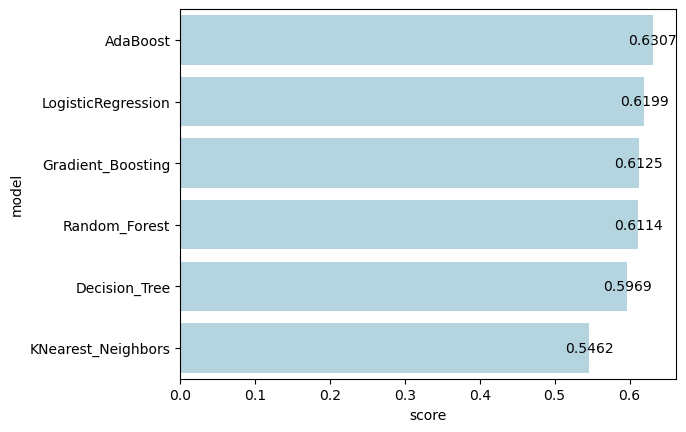

In [86]:
ax=sns.barplot(x="score",y="model",color='lightblue', data=df, order=df.sort_values('score', ascending = False).model)
for p in ax.patches:
    ax.annotate(p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(0, 0), textcoords='offset points',ha='center', va="center")

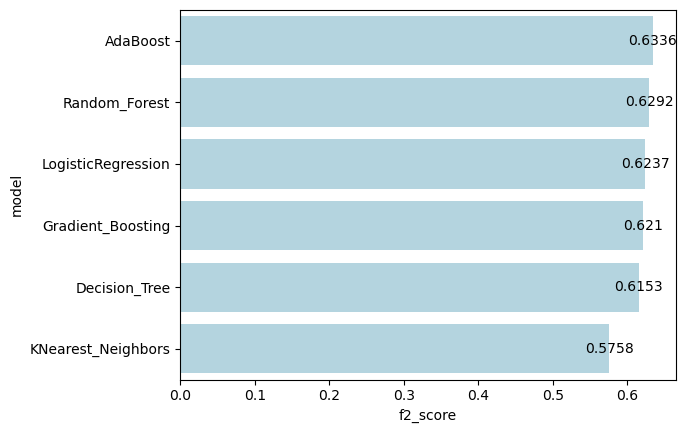

In [87]:
ax=sns.barplot(x="f2_score",y="model",color='lightblue', data=df, order=df.sort_values('f2_score',ascending = False).model)
for p in ax.patches:
    ax.annotate(p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(0, 0), textcoords='offset points',ha='center', va="center")

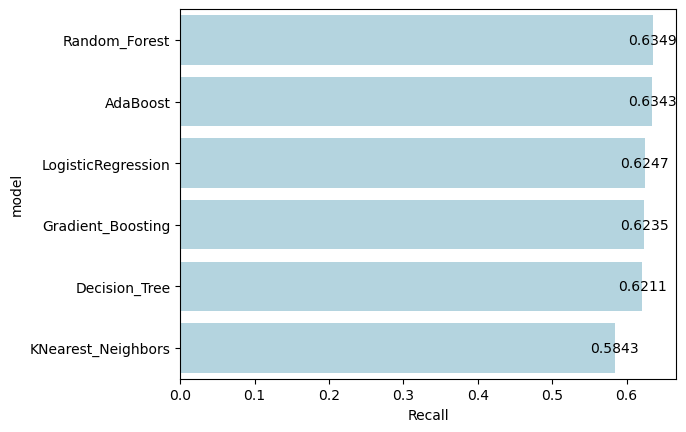

In [88]:
ax=sns.barplot(x="Recall",y="model",color='lightblue', data=df, order=df.sort_values('Recall',ascending = False).model)
for p in ax.patches:
    ax.annotate(p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(0, 0), textcoords='offset points',ha='center', va="center")

***Thus ADABOOST & Decision Tree give the better Recall. Now we are going to study the Algorithms with respect to grid search CV***

Let us check whether we improve the recall with grid search cv.

**Decision Tree+ Grid Search**

In [89]:
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5, scoring='recall')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]},
             scoring='recall')

In [90]:
# print best parameter after tuning
print(clf.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(clf.best_estimator_)

{'criterion': 'gini', 'max_depth': 8}
DecisionTreeClassifier(max_depth=8)


In [91]:
dtc = DecisionTreeClassifier(**clf.best_params_)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

In [92]:
y_pred = dtc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm
  
# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.51      0.55      4953
           1       0.58      0.67      0.62      4977

    accuracy                           0.59      9930
   macro avg       0.59      0.59      0.59      9930
weighted avg       0.59      0.59      0.59      9930



In [93]:
print('Recall for Decision Tree: ',  recall_score(y_test, y_pred))

Recall for Decision Tree:  0.6694796061884669


**Plot the feature importance of the Decision Tree model**

In [94]:
dtc.feature_importances_

array([0.01544544, 0.00276871, 0.        , 0.115298  , 0.01025141,
       0.0013369 , 0.00601809, 0.07300887, 0.0397804 , 0.04017594,
       0.19115725, 0.08675736, 0.02962256, 0.04394983, 0.02988516,
       0.00225654, 0.00190486, 0.00580107, 0.03805405, 0.00307118,
       0.00324996, 0.00387307, 0.00684244, 0.00349338, 0.00608347,
       0.00597737, 0.00268307, 0.00527086, 0.00091621, 0.00374116,
       0.00035255, 0.01006994, 0.00394499, 0.00079467, 0.009999  ,
       0.00246164, 0.00478216, 0.        , 0.07366269, 0.00131922,
       0.        , 0.01016619, 0.00929076, 0.06149378, 0.00063212,
       0.        , 0.00197468, 0.        , 0.        , 0.01321828,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00075096, 0.001374  , 0.        , 0.        ,
       0.        , 0.00288516, 0.        , 0.        , 0.        ,
       0.        , 0.0121526 ])

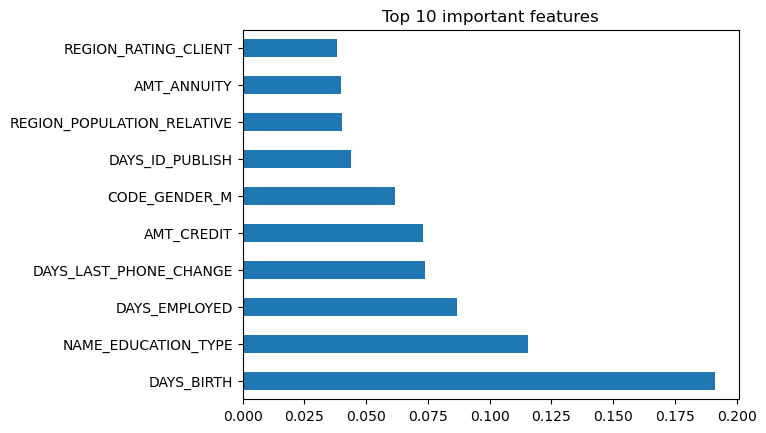

In [95]:
# Feature importance in decision tree
feat_importances = pd.Series(dtc.feature_importances_, index=X.columns)
f=feat_importances.nlargest(10)
f.plot(kind='barh')
plt.title("Top 10 important features")
plt.show()

**Adaboost+Grid Search**

In [96]:
# defining parameter range
param_grid = {'n_estimators': [75, 100, 150, 200],'learning_rate':[0.01, 0.02, 0.03, 1.0]}
  
grid = GridSearchCV(AdaBoostClassifier(), param_grid, scoring='recall')
  
# fitting the model for grid search
grid.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 1.0],
                         'n_estimators': [75, 100, 150, 200]},
             scoring='recall')

In [97]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'learning_rate': 1.0, 'n_estimators': 200}
AdaBoostClassifier(n_estimators=200)


In [98]:
Ab = AdaBoostClassifier(**grid.best_params_)
Ab.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=200)

In [99]:
y_pred = Ab.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm
  
# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      4953
           1       0.63      0.63      0.63      4977

    accuracy                           0.63      9930
   macro avg       0.63      0.63      0.63      9930
weighted avg       0.63      0.63      0.63      9930



In [100]:
print('Recall for AdaBoost: ',  recall_score(y_test, y_pred))

Recall for AdaBoost:  0.6325095439019489


**So we have managed to improve the recall by using GridSearch.**

**Plot the feature importance of the Adaboost model**

In [101]:
Ab.feature_importances_

array([0.01 , 0.   , 0.005, 0.015, 0.02 , 0.   , 0.025, 0.12 , 0.11 ,
       0.055, 0.09 , 0.035, 0.04 , 0.035, 0.025, 0.01 , 0.005, 0.005,
       0.02 , 0.005, 0.02 , 0.005, 0.   , 0.01 , 0.01 , 0.025, 0.005,
       0.005, 0.005, 0.   , 0.01 , 0.025, 0.005, 0.015, 0.03 , 0.005,
       0.01 , 0.005, 0.04 , 0.   , 0.   , 0.015, 0.01 , 0.005, 0.   ,
       0.005, 0.   , 0.   , 0.01 , 0.005, 0.   , 0.   , 0.005, 0.   ,
       0.005, 0.   , 0.   , 0.005, 0.   , 0.005, 0.005, 0.005, 0.   ,
       0.005, 0.   , 0.   , 0.   , 0.   , 0.005, 0.   , 0.   , 0.05 ])

In [102]:
feat_importances = pd.Series(Ab.feature_importances_, index=X.columns)
f=feat_importances.nlargest(10)

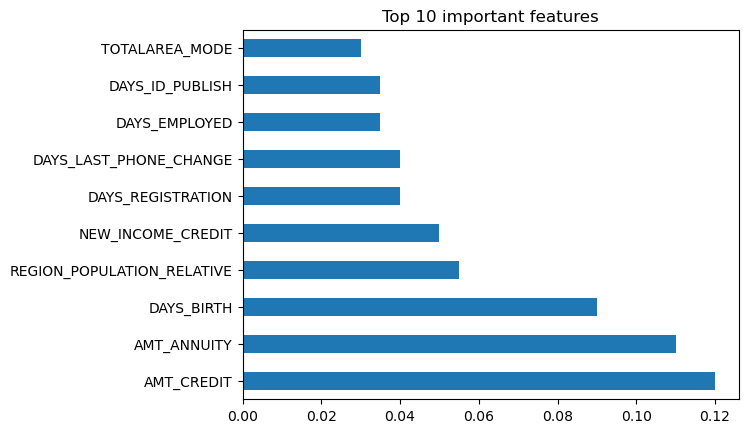

In [103]:
f.plot(kind='barh')
plt.title("Top 10 important features")
plt.show()

### Multiple Classifier Testing using GridSearchCV+ f2 score

In [104]:
f2 = make_scorer(fbeta_score, beta=2, average='macro')

In [105]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [90,100,110]
        }
    },
    'Adaboost': {
        'model': AdaBoostClassifier(),
        'params' : {
            'n_estimators': [50, 75, 100],
            'learning_rate':[0.01, 0.001, 1.0]
        }
    },
    'Gradient_Boosting': {
        'model': GradientBoostingClassifier(),
        'params' : {
            'n_estimators': [100, 100],
            'learning_rate':[0.01, 1.0]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    }
}

In [106]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], scoring=f2, cv=5, return_train_score=False)
    clf.fit(X_test, y_test)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,random_forest,0.615753,{'n_estimators': 100}
1,Adaboost,0.616240,"{'learning_rate': 1.0, 'n_estimators': 75}"
2,Gradient_Boosting,0.608256,"{'learning_rate': 0.01, 'n_estimators': 100}"
3,logistic_regression,0.619166,{'C': 10}


### Grid SearchCV + Random Forest Classifier

In [107]:
rfc = RandomForestClassifier()

In [108]:
params = {
    'n_estimators' : [100, 110, 120],
    'max_features':["log2", "sqrt"]
    }

In [109]:
f2_score = make_scorer(fbeta_score, beta=2, average='binary')
gs = GridSearchCV(estimator=rfc, param_grid=params, scoring=f2_score, cv=5, n_jobs=-1)

In [110]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'n_estimators': [100, 110, 120]},
             scoring=make_scorer(fbeta_score, beta=2, average=binary))

In [111]:
gs.best_params_

{'max_features': 'log2', 'n_estimators': 120}

In [112]:
gs.best_score_

0.6011040096451111

In [113]:
rf = RandomForestClassifier(random_state=0, **gs.best_params_)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', n_estimators=120, random_state=0)

In [114]:
rf.score(X_test, y_test)

0.6171198388721048

In [115]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[3207, 1746],
       [2056, 2921]])

In [116]:
accuracy=accuracy_score(y_test,y_pred)
Precision=precision_score(y_test, y_pred)
Recall=recall_score(y_test, y_pred)
f1score=f1_score(y_test, y_pred)
print(accuracy)
print(Precision)
print(Recall)
print(f1score)

0.6171198388721048
0.625883865438183
0.586899738798473
0.6057652426379095


### Shap for ensemble methods for Random Forest

**SHAP shows the contribution or the importance of each feature on the prediction of the model, it does not evaluate the quality of the prediction itself.**

In [117]:
x_test= pd.DataFrame(X_test, columns=X.columns)
x_test.head(1)

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,ORGANIZATION_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,NEW_INCOME_CREDIT
0,-0.293287,1.447962,0.668734,0.571851,1.399574,-0.603868,-0.348279,1.112421,0.450642,-0.82674,...,-0.160871,-0.090969,-0.355743,-0.160211,-0.435855,-0.349243,-0.236028,2.133938,-0.454611,-0.835718


In [118]:
explainer = shap.TreeExplainer(rf)
sv = explainer.shap_values(x_test.head(10))
len(sv)

2

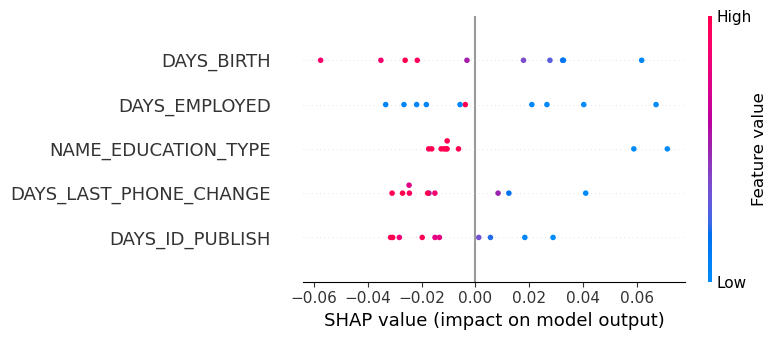

In [119]:
summary_plot(sv[0], x_test.head(10), max_display=5)

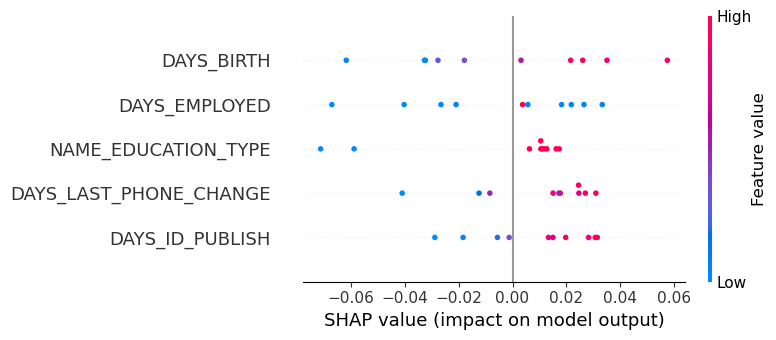

In [120]:
summary_plot(sv[1], x_test.head(10), max_display=5)

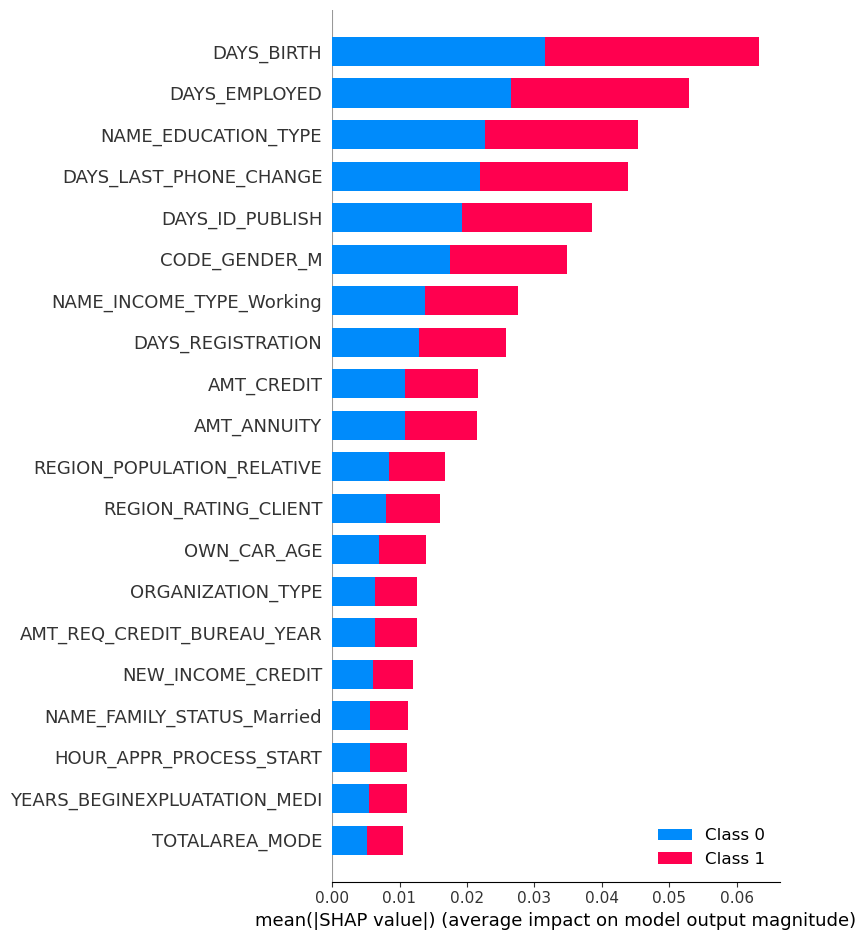

In [121]:
shap.summary_plot(sv, x_test, plot_type = 'bar')

### Grid SearchCV with Gradient Boosting

In [122]:
gboos = GradientBoostingClassifier()

In [123]:
params = {
    'n_estimators' : [90, 100, 110],
    'max_features':["log2", "sqrt"]
    }

In [124]:
f2_score = make_scorer(fbeta_score, beta=2, average='binary')
gs = GridSearchCV(estimator=gboos, param_grid=params, scoring=f2_score, cv=5, n_jobs=-1)

In [125]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'n_estimators': [90, 100, 110]},
             scoring=make_scorer(fbeta_score, beta=2, average=binary))

In [126]:
gs.best_params_

{'max_features': 'log2', 'n_estimators': 100}

In [127]:
gs.best_score_

0.6350764303174834

In [128]:
gb = GradientBoostingClassifier(**gs.best_params_)
gb.fit(X_train, y_train)

GradientBoostingClassifier(max_features='log2')

In [129]:
gb.score(X_test, y_test)

0.6260825780463243

In [130]:
y_pred = gb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[3069, 1884],
       [1829, 3148]])

In [131]:
accuracy=accuracy_score(y_test,y_pred)
Precision=precision_score(y_test, y_pred)
Recall=recall_score(y_test, y_pred)
f1score=f1_score(y_test, y_pred)
print(accuracy)
print(Precision)
print(Recall)
print(f1score)

0.6260825780463243
0.6255961844197139
0.6325095439019489
0.6290338695174343


### Plot the shap for the Gradient Boost

In [132]:
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(x_test)

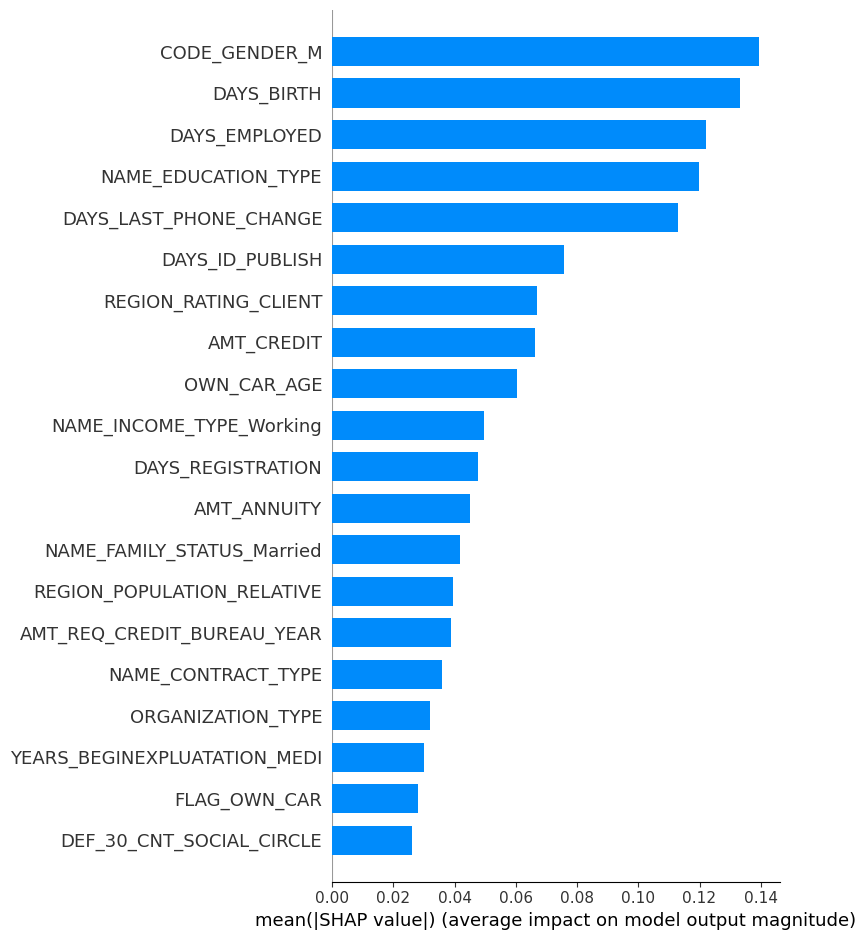

In [133]:
shap.summary_plot(shap_values, x_test, plot_type="bar")